# Longitudinal analysis

Evaluation of a subset of the data longitudinally for section 3.3, Figure 9. We pick out P0009, P0020, P0029 and P0039.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from dataframe_help import add_temperature_w0_sw, calc_contrast
from distortions_help import load_distortions_df, calc_mean_2D_dist_radius

In [2]:
def make_date(df):
    return pd.to_datetime(df['Session'].str[:8], format='%Y%m%d')

# Date filters
def filter_df(df):
    date_filter = {'P0009':['2000-01-01', '2023-12-01'],
                'P0020':['2000-01-01', '2025-01-01'],
                'P0029':['2000-01-01', '2025-01-01'],
                'P0039':['2023-10-01', '2025-01-01']}
    
    # Bad orientation in these sessions
    df.drop(df[(df['Subject'] == 'P0020') & (df['Session'].isin(['20240322121526', '20240419161029']))].index, inplace=True)

    for sub in date_filter.keys():
        df.drop(df.loc[(df.Subject==sub) & ((df.Date<date_filter[sub][0]) | (df.Date>date_filter[sub][1]))].index, inplace=True)
    
    return df

sites = ['P0029', 'P0020', 'P0039', 'P0009']

In [8]:
# Load data
df_par = pd.read_csv('../data/session_params.csv').drop(columns=['Unnamed: 0'])
df_psnr = pd.read_csv('../data/PSNR_df.csv').drop(columns=['index'])
df_psnr = add_temperature_w0_sw(df_psnr, '../data/')
df_psnr = df_psnr.drop(df_psnr[df_psnr['PSNR'] == np.inf].index).reset_index()
df_psnr = df_psnr[df_psnr.Subject.isin(sites)]
df_psnr['Date'] = make_date(df_psnr)
df_psnr = filter_df(df_psnr)

for site in sites:
    data = df_psnr.loc[df_psnr.Subject==site, 'PSNR']
    df_psnr.loc[df_psnr.Subject==site, 'RelPSNR'] = 100*(data - data.mean())/data.mean()

    data = df_psnr.loc[df_psnr.Subject==site, 'SSIM']
    df_psnr.loc[df_psnr.Subject==site, 'RelSSIM'] = 100*(data - data.mean())/data.mean()

Adding in temperature, w0 and SW: 100%|██████████| 242/242 [00:00<00:00, 1305.84it/s]


In [9]:
### Contrast Dataframe ###
contrast_references = {'Adult':
                        {
                            'WM': {'Seg':'T2', 'LabelValue':9},
                            'GM': {'Seg':'T2', 'LabelValue':8}
                        },
                        'Neo':
                        {
                            'WM':{'Seg':'T2', 'LabelValue':4},
                            'GM': {'Seg':'T2', 'LabelValue':8}
                        }
                    }

df_con = pd.read_csv('../data/contrast_df.csv')

df_con = calc_contrast(df_con, contrast_references)
df_con = add_temperature_w0_sw(df_con, '../data')
df_con = df_con[df_con.Subject.isin(sites)]
df_con['Date'] = make_date(df_con)
df_con = filter_df(df_con)

/Users/emil/Code/unity_qa_paper/notebooks/dataframe_help.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_contrast = pd.concat((df_contrast, pd.DataFrame.from_dict(D)), ignore_index=True)
Adding in temperature, w0 and SW: 100%|██████████| 242/242 [00:00<00:00, 1585.45it/s]


In [10]:
### Distortion dataframe ###
dist_df = load_distortions_df()
dist_df = add_temperature_w0_sw(dist_df, '../data')
mean_rad_df = calc_mean_2D_dist_radius(dist_df)

mean_rad_df = mean_rad_df[mean_rad_df.Subject.isin(sites)]
mean_rad_df['Date'] = make_date(mean_rad_df)
mean_rad_df = filter_df(mean_rad_df)

Removed 6 sessions


Adding in temperature, w0 and SW: 100%|██████████| 9750/9750 [00:05<00:00, 1681.16it/s]


In [11]:
# Check for software updates
for site in sites:
    print(site)
    print(df_psnr.loc[df_psnr.Subject==site, 'SoftwareVersions'].unique())

# We have updates for P0029 and P0009, find the dates
P0009_update_date = df_psnr.loc[(df_psnr.Subject=='P0009') & (df_psnr.SoftwareVersions=='rc8.7.0_Beta1'), 'Date'].min()
P0029_update_date = df_psnr.loc[(df_psnr.Subject=='P0029') & (df_psnr.SoftwareVersions=='8.7.0'), 'Date'].min()

P0029
['rc8.7.0_Beta1' '8.7.0']
P0020
['8.7.0']
P0039
['8.6.1']
P0009
['rc8.6.0' 'rc8.7.0_Beta1']


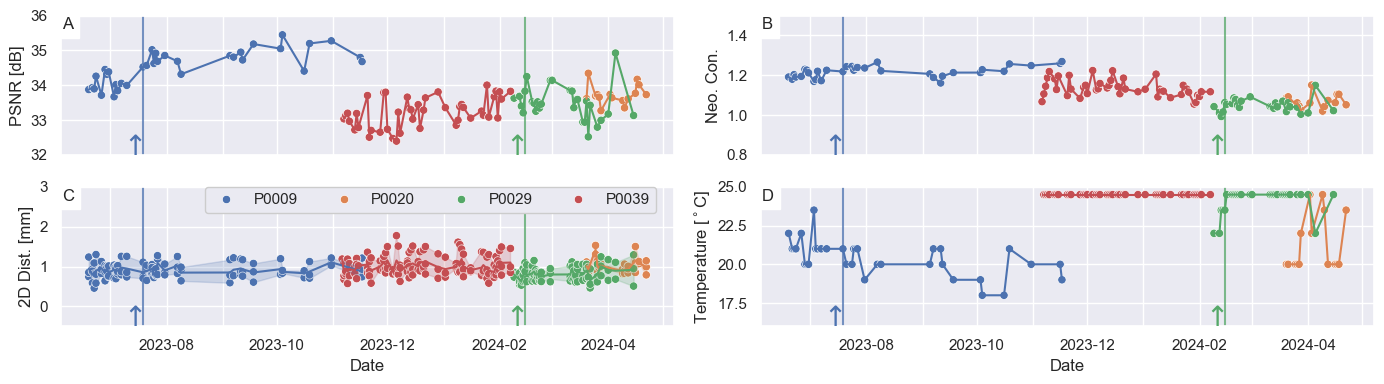

In [12]:
def add_letter(ax, fx, fy, my_string):
    y0,y1 = ax.get_ylim()
    y = y1 - (y1-y0)*fy
    ax.text(ax.get_xlim()[0]*(1+fx), y, my_string, backgroundcolor='w')

sns.set_theme()
fig, axes = plt.subplots(2,2, figsize=(14,4))

# PSNR
ax = axes[0,0]
sns.scatterplot(data=df_psnr, x='Date', y='PSNR', hue='Subject', ax=ax, legend=None)
sns.lineplot(data=df_psnr, x='Date', y='PSNR', hue='Subject', ax=ax, legend=None)
ax.set_ylabel(r'PSNR [dB]')

# Neo contrast
ax = axes[0,1]
sns.scatterplot(data=df_con, x='Date', y='Neonatal WM/GM Contrast', hue='Subject', ax=ax, legend=None)
sns.lineplot(data=df_con, x='Date', y='Neonatal WM/GM Contrast', hue='Subject', ax=ax, legend=None)
ax.set_ylabel(r'Neo. Con.')

# Distortion
ax = axes[1,0]
sns.scatterplot(data=mean_rad_df.loc[mean_rad_df.r_ref_level=='50.0'], x='Date', y='Mean_2D', hue='Subject', ax=ax)
sns.lineplot(data=mean_rad_df.loc[mean_rad_df.r_ref_level=='50.0'], x='Date', y='Mean_2D', hue='Subject', ax=ax, legend=None)
ax.set_ylabel(r'2D Dist. [mm]')

ax = axes[1,1]
sns.scatterplot(data=df_psnr, x='Date', y='Temperature', hue='Subject', ax=ax, legend=None)
sns.lineplot(data=df_psnr, x='Date', y='Temperature', hue='Subject', ax=ax, legend=None)
ax.set_ylabel(r'Temperature [$^\circ$C]')

axes[0,0].set_xlabel(None); axes[0,0].set_xticklabels([])
axes[0,1].set_xlabel(None); axes[0,1].set_xticklabels([])

axes[0,0].axis([None,None, 32, 36])
axes[0,1].axis([None,None, 0.8, 1.5])
axes[1,0].axis([None,None, -.5, 3])
axes[1,1].axis([None,None, 16, 25])

add_letter(axes[0,0], 0.4E-4, 1E-1, 'A')
add_letter(axes[0,1], 0.4E-4, 1E-1, 'B')
add_letter(axes[1,0], 0.4E-4, 1E-1, 'C')
add_letter(axes[1,1], 0.4E-4, 1E-1, 'D')

for ax in axes.flatten():
    ax_range = ax.get_ylim()
    ax.plot([P0009_update_date]*2, ax_range, '-', color='C00', alpha=0.75)
    ax.plot([P0029_update_date]*2, ax_range, '-', color='C02', alpha=0.75)

    ax.text(P0009_update_date, ax_range[0], r'$\uparrow$', fontsize=20, horizontalalignment='right', color='C00')
    ax.text(P0029_update_date, ax_range[0], r'$\uparrow$', fontsize=20, horizontalalignment='right', color='C02')

    
axes[1,0].legend(bbox_to_anchor=(.97, 1), loc='upper right', borderaxespad=0., ncol=4).get_frame().set_alpha(1)

for ax in [axes[1,0], axes[1,1]]:
    for label in ax.get_xticklabels()[::2]:
        label.set_visible(False)

plt.tight_layout()
plt.savefig('../results/figure9_longitudinal.png', dpi=300)
plt.show()

In [13]:
# Average changes over time
print("--- PSNR ---")
for site in sites:
    data = df_psnr.loc[df_psnr.Subject==site, 'PSNR']
    print(f"{site}: {data.mean():.2f} ({data.std()*1.96:.2f})")

print("\n--- Neo Contrast ---")
for site in sites:
    data = df_con.loc[df_con.Subject==site, 'Neonatal WM/GM Contrast']
    print(f"{site}: {data.mean():.2f} ({data.std()*1.96:.2f})")

print("\n--- Distortions ---")
for site in sites:
    data = mean_rad_df.loc[(mean_rad_df.Subject==site) & (mean_rad_df.r_ref_level=='50.0'), 'Mean_2D']
    print(f"{site}: {data.mean():.2f} ({data.std()*1.96:.2f})")

--- PSNR ---
P0029: 33.50 (0.95)
P0020: 33.72 (0.54)
P0039: 33.22 (0.84)
P0009: 34.53 (0.94)

--- Neo Contrast ---
P0029: 1.05 (0.06)
P0020: 1.07 (0.07)
P0039: 1.13 (0.08)
P0009: 1.22 (0.06)

--- Distortions ---
P0029: 0.81 (0.36)
P0020: 1.01 (0.35)
P0039: 1.02 (0.48)
P0009: 0.91 (0.36)
